<a href="https://colab.research.google.com/github/Khamphang/test-repositry/blob/master/DL_Assignment_3_Regularization_and_1_notmnist_na.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1: notmnist

In [2]:
### 200525 ເຮົາຈະ downgrade ຂອງ tensorflow ຈາກ 2.x ເປັນ 1.x ເພື່ອໃຊ້ກັບ Assignment 3 Regularization
%tensorflow_version 1.x

import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)

TensorFlow 1.x selected.
1.15.2
2.2.4-tf


In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
### ຄຳຕອບຂອງ Assignment ນີ້: http://www.ritchieng.com/machine-learning/deep-learning/tensorflow/notmnist/

from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
###       ໂຕ import ລຸ່ມນີ້ແມ່ນ ນາເພີ່ມໃສ່        ###
import imageio

from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

###   ຖ້າໜ້າແຖວມີ ### ແມ່ນແຖວນັ້ນນາເພີ່ມໃສ່  
np.set_printoptions(precision=2)
###import pdb
###  import pdb; pdb.set_trace()   ###   ນາ    ####
###   ນາເພີ່ມໃສ່     ####

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine. 

ບໍ່ຮູ້ວ່າຫຼັງຈາກ download ແລ້ວມັນໄປຢູ່ບ່ອນໃດຂອງ notebook ນີ້ ຖ້າຈະເປີດດ້ວຍ window explorer ມັນຈະຢູ່ບ່ອນໃດນໍ

Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [4]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere
# data_root = u'C:' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
## Na ## def maybe_download(filename, expected_bytes, force=True):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified ./notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified ./notMNIST_small.tar.gz


In [5]:
num_classes = 10
np.random.seed(133)   ## 133 ໝາຍເຖິງຫຍັງນໍ ??? An array of random numbers in the [0.0, 1.0]

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))         # The method len() returns the 
  print(data_folders)                            # number of elements in the list
  return data_folders
  
train_folders = maybe_extract(train_filename)    # train_folders ເປັນ list ເກັບທີ່
test_folders = maybe_extract(test_filename)      # ຢູ່ຂອງຮູບຕາມແຕ່ລະໂຕອັກສອນ ເຊັ່ນ:
                                                 # './notMNIST_large/D'

Extracting data for ./notMNIST_large. This may take a while. Please wait.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
Extracting data for ./notMNIST_small. This may take a while. Please wait.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [6]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

# We get all file names in I directory
fn = os.listdir("notMNIST_small/I/")

# Display first 1 images of I directory
for file in fn[0:2]:
    path = 'notMNIST_small/I/' + file

    image_data_Na = imageio.imread(path).astype(float)

    print(image_data_Na)

    display(Image(path))

    image_data_Na = (image_data_Na - pixel_depth / 2) / pixel_depth  # ຂັ້ນຕອນນີ້ຄິດວ່າແມ່ນ່ປ່ຽນຮູບຕົວເລກແຕ່ລະພິກເຊວຮູບເປັນຮູບແບບ zero mean and standard deviation ~0.5     
                   # to make training easier down the road ເພື່ອງ້າຍໃນການປະຜົນຂອງຄອມ

    print(image_data_Na)

    display(Image(path))



[[255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 2

[[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.

[[124. 236. 255. 255. 255. 254. 253. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255. 255. 253. 254. 255. 255. 255. 240. 149.]
 [ 79. 165. 187. 204. 231. 250. 255. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255. 255. 255. 251. 233. 207. 188. 169.  96.]
 [  0.   0.   0.   3.  18.  77. 177. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255. 255. 178.  79.  20.   3.   0.   0.   0.]
 [  1.   2.   1.   0.   0.   0.  74. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255. 255.  74.   0.   0.   0.   1.   2.   2.]
 [  0.   0.   0.   1.   2.   2.  74. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255. 255.  74.   2.   2.   1.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.  74. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255. 255.  74.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.  74. 255. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255. 255.  74.   0.   0.   0.  

[[-0.01  0.43  0.5   0.5   0.5   0.5   0.49  0.5   0.5   0.5   0.5   0.5
   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.49  0.5   0.5
   0.5   0.5   0.44  0.08]
 [-0.19  0.15  0.23  0.3   0.41  0.48  0.5   0.5   0.5   0.5   0.5   0.5
   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.48  0.41
   0.31  0.24  0.16 -0.12]
 [-0.5  -0.5  -0.5  -0.49 -0.43 -0.2   0.19  0.5   0.5   0.5   0.5   0.5
   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.2  -0.19 -0.42
  -0.49 -0.5  -0.5  -0.5 ]
 [-0.5  -0.49 -0.5  -0.5  -0.5  -0.5  -0.21  0.5   0.5   0.5   0.5   0.5
   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5  -0.21 -0.5  -0.5
  -0.5  -0.5  -0.49 -0.49]
 [-0.5  -0.5  -0.5  -0.5  -0.49 -0.49 -0.21  0.5   0.5   0.5   0.5   0.5
   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5  -0.21 -0.49 -0.49
  -0.5  -0.5  -0.5  -0.5 ]
 [-0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.21  0.5   0.5   0.5   0.5   0.5
   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5  -0.

In [7]:
# Display first 8 images ສະແດງ 8ໂຕທຳອິດ
for file in fn[:8]:
    path = 'notMNIST_small/I/' + file
##    print (path)
    display(Image(path))

###   ນາເພີ່ມໃສ່  ###
###    import pdb; pdb.set_trace()

In [8]:
###   ນາເພີ່ມໃສ່   ເພື່ອຊອກຈຳນວນຟ້າຍໃນ ໂຟນເດີ(ໄດເລັກໂຕຣີ) ###
# list = os.listdir(fn) # fn is your directory path
dir = os.listdir("notMNIST_large/D/")
number_files = len(dir)
print ('ຈຳນວນຮູບໃນໂຟນເດີ [notMNIST_large/D/]: ',number_files,'ຮູບ')

dir = os.listdir("notMNIST_large/I/")
number_files = len(dir)
print ('ຈຳນວນຮູບໃນໂຟນເດີ [notMNIST_large/I/]: ',number_files,'ຮູບ')

ຈຳນວນຮູບໃນໂຟນເດີ [notMNIST_large/D/]:  52912 ຮູບ
ຈຳນວນຮູບໃນໂຟນເດີ [notMNIST_large/I/]:  52912 ຮູບ


In [9]:
print(test_folders)
print(path)
display(Image(path))
image_file = path


# import imageio
# im = imageio.imread('astronaut.png')

image_data_Na = imageio.imread(image_file).astype(float)

print(image_data_Na) ### ເບິ່ງຄ່າແຕ່ລະພິເຊວກ່ອນເປັນ zero mean and standard deviation ~0.5 to make training easier down the road

pixel_depth_Na = 255.0  # Number of levels per pixel.
image_data_Na = (image_data_Na - pixel_depth_Na / 2) / pixel_depth_Na
print(image_data_Na) ### ເບິ່ງຄ່າແຕ່ລະພິເຊວເມື່ອປ່ຽນເປັນ zero mean and standard deviation ~0.5 to make training easier down the road

['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']
notMNIST_small/I/RWxsaW5ndG9uIE1UIEJvbGQudHRm.png


[[210. 255. 255. 255. 255. 255. 255. 254. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 254. 255. 198.]
 [ 50.  65.  64.  66.  75.  91. 139. 241. 255. 254. 255. 255. 255. 255.
  255. 255. 255. 255. 254. 255. 240. 133.  85.  73.  66.  64.  65.  48.]
 [  0.   0.   0.   0.   0.   5.   0. 160. 255. 255. 255. 255. 255. 255.
  255. 255. 255. 255. 255. 251. 113.   0.   3.   0.   0.   0.   0.   0.]
 [  2.   3.   3.   3.   3.   6.   0.  99. 249. 255. 255. 255. 255. 255.
  255. 255. 255. 254. 255. 238.  45.   0.   5.   3.   3.   3.   3.   2.]
 [  0.   0.   0.   0.   0.   2.   0.  71. 243. 255. 254. 255. 255. 255.
  255. 255. 255. 254. 255. 235.  27.   0.   1.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   2.   0.  48. 239. 255. 254. 255. 255. 255.
  255. 255. 255. 254. 255. 232.  12.   0.   1.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   1.   0.  30. 236. 255. 254. 255. 255. 255.
  255. 255. 255. 254. 255. 230.   2.   1.   0.   0.   0.  

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.
 
ພວກເຮົາຈະແປງຊຸດຂໍ້ມູນເປັນ 3D array (image index, x, y) ເປັນຕົວເລກປະເພດ float ໃນຮູບຕົວເລກ zero mean ແລະ standard deviation ~0.5 ເພື່ອງ້າຍໃນການປະຕິບັດ

A few images might not be readable, we'll just skip them.

..... ໝາຍເຫດ .....: os.listdir(folder) ໝາຍເຖິງຊື່ file ທັງໝົດທີ່ມີຢູ່ໃນໂຟເດີ ຕາມທີ່ຢູ່ທີ່ບອກດ້ວຍຕົວປ່ຽນ "folder"

In [10]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""

###  print (" ຢູ່ໃນ load_letter method")

  image_files = os.listdir(folder)                              # ໂລດຊື່ file ທັງໝົດທີ່ມີຢູ່ໃນໂຟເດີ (folder) ໃສ່ image_files
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)                      # np.ndarray ແມ່ນປ່ຽນຮູບທັງໝົດເປັນຕົວປ່ຽນ tuple ໂຕດ່ຽວ
  print('ຂະໜາດ dataset ກ່ອນຂັດຮູບໃຊ້ບໍ່ໄດ້ອອກ: ', dataset.shape)     ###   ແຖວນີ້ນາເພີ່ມໃສ່
  print(folder)
  
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:                                                         # ຂັ້ນຕອນນີ້ພະຍາມອ່ານຟ້າຍຮູບຖ້າອ່ານບໍ່ໄດ້ກໍ່ຈະຂັດອອກ

###      image_data = (ndimage.imread(image_file).astype(float) -   # ຄຳສັງເກົ່າໃຊ້ເກັບ Pyton V2.7 "ndimage"
      image_data = (imageio.imread(image_file).astype(float) -   # ຂັ້ນຕອນນີ້ຄິດວ່າແມ່ນ່ປ່ຽນຮູບຕົວເລກແຕ່ລະພິກເຊວຮູບເປັນຮູບແບບ zero mean and standard deviation ~0.5     
                    pixel_depth / 2) / pixel_depth               # to make training easier down the road ເພື່ອງ້າຍໃນການປະຜົນຂອງຄອມ


      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
###    except IOError as e:        ### # ຄຳສັງເກົ່າໃຊ້ເກັບ Pyton V2.7 "IOError"
    except Exception as e:

      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
      print ("image ທີ່: " + str(num_images) + "ສະແດງຄ່າ image_file: " + image_file)   

  dataset = dataset[0:num_images, :, :]     ### ແຖວນີ້ອັບເດດຈຳນວນຮູບຫຼັງຈາກຄັດຮູບທີ່ໃຊ້ບໍ່ໄດ້ອອກແລະຈັດລຽນຮູບເຂົ້າມາພ້ອມແລ້ວ
  
                                         ### ເພື່ອຂະໜາດຂອງອາເລເທົ່າຈຳນວນຮູບທີ່ໃຊ້ໄດ້
###   171224 ນາ    ####

  if num_images < min_num_images:        ### ຫຼັງຈາກຄັດເອົາຮູບທີ່ໃຊ້ບໍ່ໄດ້ເອົາແລ້ວ ກໍ່ກວດເບິ່ງຈຳນວນທີ່ໃຊ້ໄດ້ມັນໃຫຍ່ກວ່າຈຳນວນຕໍ່າສຸດທີ່ເຮົາຕ້ອງການຫລືບໍ່
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))           ### ???
  print('Standard deviation:', np.std(dataset))   ### ???
  return dataset

###   171225 ນາ    ####

def maybe_pickle(data_folders, min_num_images_per_class, force=False):

  print (data_folders)
  dataset_names = []
  for folder in data_folders:                               # ຮອບທຳອິດ ເອົາຄ່າຫ້ອງທີ່1 ຂອງອາເລ້ data_folders ໃສ່ folder ຮອບຕໍ່ໄປກໍ່ເອົາຫ້ອງຕໍ່ໄປຈົນຮອດສຸດທ້າຍ
    set_filename = folder + '.pickle'                       # ເຊັນ './notMNIST_large/A', './notMNIST_large/B', ...
    dataset_names.append(set_filename)                      # ລວມທີ່ຢູ່ພ້ອມຊື່ຟ້າຍນາມສະກຸນ .pickle ຂອງແຕ່ລະຕົວອັກສອນໃສ່ dataset_names ເພື່ອ
    
    print (set_filename)

    if os.path.exists(set_filename) and force:          # ຫຼັງເປັນຮູບເປັນຮູບເປັນຟ້າຍ .pickle ກໍ່ return ພຽງທີ່ຢູ່ພ້ອມຊື່
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class) # ແຖວນີ້ໂລດກຸ່ມຮູບໃສ່ອາເລໂຕດຽວເພື່ອໄວ້ປ່ຽນເປັນຟ້າຍ .pickle
      try:
        with open(set_filename, 'wb') as f:                  #  ເປີດຟາຍຕາມ set_filename ໃນແບບ 'wb' ເປັນໄບນາລີແລະສາມາດຂຽນໃສ່ຟາຍໄດ້
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)   # ແຖວນີ້ປ່ຽນອາເລເປັນຟ້າຍ .pickle  ຕົວຢ່າງ A.pickle
      except Exception as e:                                 # ຕົວຢ່າງຂອງ pickle.dump ຢູ່ https://kite.com/docs/python;pickle.dump
        print('Unable to save data to', set_filename, ':', e)       
  print("ຄ່າ dataset_names ກ່ອນສົ່ງກັບ" + str(dataset_names))
  return dataset_names                                       # ສົ່ງຄືນຊື່ ແລະ ທີ່ຢູ່ຂອງ dataset ໂດຍເປັນ list ຂອງstring ເຊັນ ['./notMNIST_large/A.pickle', './notMNIST_large/B.pickle', './notMNIST_large/C.pickle', './notMNIST_large/D.pickle',
                                                             # './notMNIST_large/E.pickle', './notMNIST_large/F.pickle', './notMNIST_large/G.pickle', './notMNIST_large/H.pickle', './notMNIST_large/I.pickle', './notMNIST_large/J.pickle']
###print (type(train_folders))

print ("ກ່ອນເລີ້ມ pickle: " + str(train_folders[0]))
train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

###   200421 ນາ    ####
###   171229 ນາ    ####

ກ່ອນເລີ້ມ pickle: ./notMNIST_large/A
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_large/A.pickle
Pickling ./notMNIST_large/A.pickle.
ຂະໜາດ dataset ກ່ອນຂັດຮູບໃຊ້ບໍ່ໄດ້ອອກ:  (52912, 28, 28)
./notMNIST_large/A
Could not read: ./notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
image ທີ່: 16403ສະແດງຄ່າ image_file: ./notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png
Could not read: ./notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
image ທີ່: 31272ສະແດງຄ່າ image_file: ./notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png
Could not read: ./notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : Could not find a format to read the specif

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

ຄວາມກວ້າງຂອງ len(letter_set): 52912
ຄ່າ sample_idx ທີ່ຊຸມໄດ້: 29752
[[-0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5
  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.47
   0.07  0.3  -0.15 -0.5 ]
 [-0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5
  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.49 -0.48 -0.5  -0.5
  -0.5  -0.36  0.41 -0.35]
 [-0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5
  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.49 -0.5  -0.5  -0.5  -0.38
  -0.15  0.23  0.5  -0.19]
 [-0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5
  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.49 -0.5  -0.38 -0.01  0.26  0.43
   0.5   0.5   0.01 -0.5 ]
 [-0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.49 -0.48
  -0.49 -0.49 -0.48 -0.49 -0.5  -0.49 -0.5  -0.16  0.44  0.5   0.5   0.5
   0.28 -0.32 -0.36 -0.08]
 [-0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.49 -0.5  -

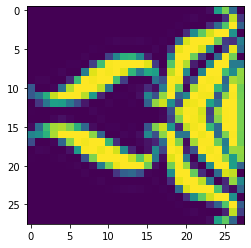

In [11]:

# index 0 should be all As, 1 = all Bs, etc. ອິນເດັດ(Index ຫຼື Label) 0 ໝາຍເຖິງກຸ່ມຕົວອັກສອນ 'A', ອິນເດັດ 1 ໝາຍເຖິງ  'B'

pickle_file = train_datasets[8]  

# With would automatically close the file after the nested block of code
with open(pickle_file, 'rb') as f:
    
    # unpickle
    letter_set = pickle.load(f)  
    
    # pick a random image index
    ### sample_idx = 0      # The method len() returns the number of elements in the list ເລືອກເອົາຮູບທຳອິດຂອງ ໃນກຸ່ມຕົວອັກສອນທີ່ເລືອກ
    sample_idx = np.random.randint(len(letter_set))      # The method len() returns the number of elements in the list
    print("ຄວາມກວ້າງຂອງ len(letter_set): " + str(len(letter_set)))
    print("ຄ່າ sample_idx ທີ່ຊຸມໄດ້: " + str(sample_idx))
                                                         # ຊຸ່ມເອົາເລກໃດໜຶ່ງ ແຕ່ 0 ຫາ 52912 = len(letter_set) ກໍ່ຄືຊຸມເອົາຮູບໃດໜຶ່ງໃນ train_datasets[8]
    # extract a 2D slice    
    sample_image = letter_set[sample_idx, :, :]          # ໂລດຮູບໂຕທີ່ sample_idx ໃສ່ sample_image ເຊິ່ງເປັນຮູບ 2D 

    ## sample_image = letter_set[7, :, :]          # ຖ້າບໍ່ຢາກຊຸມກໍ່ໃຊ້ແຖວນີ້ກໍ່ໄດ້ 

    plt.figure()
    
    # display it ສະແດງຮູບເພື່ອກວດເບິ່ງວ່າຮູບທີ່ໄດ້ມາມັນດີບໍ່
    plt.imshow(sample_image)
                    
    print(sample_image)   # ເປັນຫຍັງຕົວເລກພວກນີ້ມີຄ່າດຽວຢູ່ໃນພິກເຊວເມື່ອສ້າງເປັນຮູບຄືບໍ່ເປັນຮູບຂາວດຳ

# Problem 3

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that. 'balanced across classes' ເພື່ອຫຼຸດໂອກາດເກີດຄວາມຜິດພາດໃນການ Training ເຮົາຄວນໃຫ້ມີຈຳນວນສົມດຸ່ນກັນລະຫວ່າງແຕ່ລະ classes ແຕ່ A ຮອດ J

---

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.
ທີ່ຜ່ານມາໄດ້ shuffle ຮູບໃນແຕ່ລະກຸ່ມຕົວອັກສອນ ແລ້ວຈຶ່ງໂລດໃສ່ valid_dataset, valid_labels, train_dataset, train_labels, test_dataset, ແລະ test_labels ເມື່ອໂລດໃສ່ແລ້ວພວກມັນຍັງແຍກເປັນຊັ້ນແຕ່ລະຕົວອັກສອນ ສະນັ້ນເພື່ອໃຫ້ໃກ້ກັບຕົວຈິງຫຼາຍຂື້ນກໍ່ຕ້ອງ random ລຳດັບທັງ່ໝົດໃໝ່ໝົດຂອງ valid_dataset, valid_labels, train_dataset, train_labels, test_dataset, ແລະ test_labelsໂດຍການຈັບຄູ່ຂອງຂໍ້ມູນ ແລະ ລາບິວຂອງຖືກຄູ່ກັນຢູ່

In [12]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):    # ສຳລັບຄ່າ valid_size=0 ມັນຈະເທົ່າ 0 ຖ້າໂຕເອີ້ນຟັງຊັນນີ້ບໍ່ໃຫ້ຄ່າ valid_size  
# ຟັງຊັນນີ້ລວມ
###                  ອະທິບາຍໂຕຫຍໍ້ 
#   _v ໝາຍເຖິງ _validation
#   _t ໝາຍເຖິງ _training
#   _l ໝາຍເຖິງ All ຄືຈຳນວນ _v + _t ກໍ່ຄຳ ( end_l = vsize_per_class+tsize_per_class )
    
  num_classes = len(pickle_files)                              # ເອົາເລກທີ່ເທົ່າກັບຈຳນວນ list ພາຍໃນຕົວປ່່ຽນປະເພດ List ກໍ່ຄື 10 lists ຂອງ pickle_files
  print("ຄວາມກວ້າງຂອງ ຫຼື ຈຳນວນ list ຂອງ pickle_files: " + str(len(pickle_files)))

  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):     # enumerate ສ້າງເລກລຳດັບຈັບຄູ່ກັບແຕ່ລະອົງປະກອບ ກໍ່ຄືລຳດັບ 0 ແທນໃຫ້ອົງປະກອບທຳອິດ
    try:                                                 # ໝາຍຄວາມວ່າລຳດັບ 0 ແທນໃຫ້ຕົວອັກສອນ A ເພາະ A ແມ່ນອົງປະກອບທຳອິດຂອງ pickle_files
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random  and training set
        np.random.shuffle(letter_set)         # shuffle ເຮັດໃຫ້ຈັດລຳດັບໃໝ່ແບບຊຸ່ມເດົາພາຍໃນ letter_set ກໍ່ຄືພາຍໃນກຸ່ມຕົວອັກສອນຂອງມັນ ຕົວຢ່າງ https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.shuffle.html
        
        # ຫຼັງຈາກຈັດລຳດັບໃໝ່ແບບຊຸ່ມເດົາແລ້ວຈຶ່ງປ້ອນຮູບໃສ່  valid_dataset ແລະ ໃສ່ train_dataset ໂດຍເອົາແຕ່ລຳດັບ 0(ຕົວອັກສອນ A) ຈົນໝົດຕໍ່ດ້ວຍ ລຳດັບ 1(ຕົວອັກສອນ B) ສຸດທ້າຍຮອດ ລຳດັບ 9(ຕົວອັກສອນ J)
        # ແລ້ວກໍ່ຈະໄດ້ valid_dataset, valid_labels, train_dataset, train_labels ທີ່ມີທຸກຕົວອັກສອນ ພ້ອມລຽນລຳດັບຈັບຄູ່ກັບ label ຂອງມັນເອງ ກໍ່ຄື valid_dataset ຄູ່ກັບ valid_labels ແລະ ຄູ່ອື່ນໆ
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]    
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
###  print('label :', label)
###  print('vsize_per_class: ',vsize_per_class)

  return valid_dataset, valid_labels, train_dataset, train_labels
            
train_size = 200000      # ຂະໜາດຈາກ ຕົວຢ່າງເຂົາເຈົ້າ
valid_size = 10000
test_size = 10000
  
## train_size = 2000 * 4  # ເນື່ອງຈາກຈຳນວນຝຶກແອບມີຮອດປະມານ 500000ໂຕ ແຕ່ຄອມຂ້ອຍສາມາດຝຶກແອບໄດ້ປະມານພຽງ 10000 ໂຕຝຶກແອບ
## valid_size = 150 * 4   # ຂະໜາດຂໍ້ມູນທີ່ໃຊ້ທົດລອງ
## test_size = 100 * 4

# ຄຳສັ່ງແຖວຂ້າງລູ່ມນີ້ເລືອກເອົາບັນດາຕົວຝຶກແອບອອກເປັນ 2ກຸ່ມຄື: ກຸ່ມຝຶກແອບ ແລະ ກຸ່ມທົດລອງ ຕາມກຳນົດຂ້າງເທິງ ໂດຍເລືອກເອົາແບບຊຸ່ມເອົາ 'shuffle'
valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)         

_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

### 200510

ຄວາມກວ້າງຂອງ ຫຼື ຈຳນວນ list ຂອງ pickle_files: 10
ຄວາມກວ້າງຂອງ ຫຼື ຈຳນວນ list ຂອງ pickle_files: 10
Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [13]:
def randomize(dataset, labels):    
  permutation = np.random.permutation(labels.shape[0])   # ເປັນຄຳສັງສະລັບລຳດັບຂອງອົງປະກອບແບບຊຸມ ໃນແຖວນີ້ຈະສະລັບເລກລຳດັບແຕ່ 0 ຫາ ລຳດັບໃຫຍ່ສຸດ
                                                         # ຂອງ labels ກໍ່ຄືເລກ labels.shape[0]
                                                         # np.random.permutation() Randomly permute a sequence, or return a permuted range.
                                                         # If x is a multi-dimensional array, it is only shuffled along its first index.
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

  
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

Finally, let's save the data for later reuse:

In [14]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')     # ຟາຍ 'notMNIST.pickle' ເຮັດໜ້າທີ່ເກັບຂໍ້ມູນທັງໝົດໃຊ້ໃຫ້ຄອມຮຽນຮູ້ຕົວອັກສອນ
                                                             # ເຊິ່ງຂໍ້ມູນນັ້ນເປັນໄບນາລີ ຢູ່ໃນຕົວປ່ຽນແບບ array
try:
  f = open(pickle_file, 'wb') 
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()                                                   # ລະສົງໃສວ່າມັນແພັກເອົາໄວ້ເຮັດຫຍັງ ອີ່ແທ້ມັນເອົາໄປໃຊ້ Assignment 3

except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [15]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)        ### ຕົວເລກທີ່ມັນສະແດງອອກມາໜ້າຈະແມ່ນ byte

###   200510 ນາ    ####
###   200421 ນາ    ####
###   180101 ນາ    ####

Compressed pickle size: 690800506


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [16]:
import time

def check_overlaps(images1, images2):
    images1.flags.writeable=False
    images2.flags.writeable=False
    start = time.clock()
    hash1 = set([hash(image1.tobytes()) for image1 in images1])
    hash2 = set([hash(image2.tobytes()) for image2 in images2])
    all_overlaps = set.intersection(hash1, hash2)
    return all_overlaps, time.clock()-start

r, execTime = check_overlaps(train_dataset, test_dataset)    
print('Number of overlaps between training and test sets: {}. Execution time: {}.'.format(len(r), execTime))

r, execTime = check_overlaps(train_dataset, valid_dataset)   
print('Number of overlaps between training and validation sets: {}. Execution time: {}.'.format(len(r), execTime))

r, execTime = check_overlaps(valid_dataset, test_dataset) 
print('Number of overlaps between validation and test sets: {}. Execution time: {}.'.format(len(r), execTime))

Number of overlaps between training and test sets: 1123. Execution time: 0.6411429999999996.
Number of overlaps between training and validation sets: 928. Execution time: 0.611725999999976.
Number of overlaps between validation and test sets: 62. Execution time: 0.05842499999999973.


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

Training: (50, 28, 28) (50,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)

ໃຊ້      50 training samples ແລະ GPU ຜົນໄດ້ຮັບ  0.6864                     ໃຊ້ເວລາ 1.4ວິນາທີ
ໃຊ້    100 training samples ແລະ GPU ຜົນໄດ້ຮັບ  0.7786                     ໃຊ້ເວລາ 1.2ວິນາທີ
ໃຊ້  1000 training samples ແລະ GPU ຜົນໄດ້ຮັບ  0.8305                     ໃຊ້ເວລາ 2.5ວິນາທີ
ໃຊ້  5000 training samples ແລະ GPU ຜົນໄດ້ຮັບ  0.8368                     ໃຊ້ເວລາ 20.1ວິນາທີ

---


In [17]:
# Here you have 200000 samples
# 28 x 28 features
# We have to reshape them because scikit-learn expects (n_samples, n_features)
train_dataset.shape

###  print(train_dataset)
###  display(train_dataset)

(200000, 28, 28)

In [18]:
### test_dataset.shape

### print(test_dataset)

In [19]:
# Prepare training data
samples, width, height = train_dataset.shape

print(train_dataset)

X_train = np.reshape(train_dataset,(samples,width*height))     ###  ເນື່ອງຈາກ ເຮົາຈະໃຊ້ LogisticRegression model from sklearn.linear_model ເຊິ່ງມັນກຳນົດໃຫ້ ຕ້ອງປ້ອນຂໍ້ມູນແບບ (n_samples, n_features)
y_train = train_labels                                         ###  ສະນັ້ນເຂົາຈຶ່ງເປັນຮູບຮ່າງຂໍ້ມູນ ຈາກ 3ມີຕິ ເປັນ 2ມິຕີ ດ້ວຍຄຳສັ່ງ reshape




# Prepare testing data
samples, width, height = test_dataset.shape
X_test = np.reshape(test_dataset,(samples,width*height))
y_test = test_labels

[[[-0.5  -0.5  -0.5  ...  0.46  0.5   0.03]
  [-0.5  -0.5  -0.5  ...  0.5   0.49 -0.28]
  [-0.5  -0.5  -0.5  ...  0.5   0.31 -0.47]
  ...
  [-0.5  -0.5  -0.5  ... -0.5  -0.5  -0.5 ]
  [-0.09  0.21  0.29 ... -0.5  -0.5  -0.5 ]
  [ 0.28  0.5   0.46 ... -0.5  -0.5  -0.5 ]]

 [[-0.5  -0.5  -0.5  ...  0.05 -0.41 -0.5 ]
  [-0.5  -0.5  -0.5  ...  0.5   0.22 -0.46]
  [-0.5  -0.5  -0.5  ...  0.47  0.5  -0.34]
  ...
  [-0.5  -0.5  -0.5  ... -0.5  -0.5  -0.5 ]
  [-0.5  -0.5  -0.5  ... -0.5  -0.5  -0.5 ]
  [-0.5  -0.5  -0.5  ... -0.5  -0.5  -0.5 ]]

 [[-0.5  -0.5  -0.5  ... -0.49 -0.5  -0.5 ]
  [-0.5  -0.5  -0.5  ...  0.31 -0.05 -0.43]
  [-0.5  -0.5  -0.5  ...  0.49  0.5   0.01]
  ...
  [-0.5  -0.5  -0.49 ... -0.5  -0.49 -0.5 ]
  [-0.5  -0.5  -0.5  ... -0.5  -0.49 -0.5 ]
  [-0.5  -0.5  -0.5  ... -0.5  -0.5  -0.5 ]]

 ...

 [[-0.5  -0.5  -0.5  ... -0.27 -0.45 -0.5 ]
  [-0.5  -0.5  -0.5  ...  0.49  0.39 -0.03]
  [-0.5  -0.5  -0.5  ...  0.49  0.5   0.19]
  ...
  [-0.5  -0.5  -0.5  ...  0.48  0.5   0.

# ຜົນການເຝືກແບບໃຊ້ LogisticRegression form sklearn ໄປປະມານ accuracy score = 0.8997 ຈາກ train dataset = 200,000ຮູບ

In [20]:
# Import
from sklearn.linear_model import LogisticRegression

# Instantiate
lg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42, verbose=1, max_iter=1000, n_jobs=-1)

# Fit   ### Fit the model according to the given training data
lg.fit(X_train, y_train)   ###---     ແຖວນີ້ແມ່ນຄຳສັ່ງໃຫ້ເຝິກແອບ(fit the model)     ---###

# Predict
y_pred = lg.predict(X_test)   ###--- ຫຼັງຈາກຮຽນແລ້ວກໍ່ມາທົດສອບກັບຊຸດຂໍ້ມູນ X_test ຊຶ່ງຜົນການທົດສອບເກັບໄວ້ຢູ່ y_pred       ---###

# Score
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)    ###--- ຫຼັງຈາກທົດສອບແລ້ວກໍ່ມາເບິ່ງຄວາມແນ່ນອນໂດຍທຽບກັນລະຫວ່າງ y_test ກັບ  y_pred     ---###

###   180106 ນາ    ####

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 24.4min finished


0.8969

In [21]:
###   180603 ສືກສາຄືນເປັນຄັ້ງທີ່ 2  ຜົນໄດ້ຮັບໂອກາດແທ້ຕ້ອງແມ່ນ 86.79999999%  ####

190505

Training: (10000, 28, 28) (10000,)
Validation: (750, 28, 28) (750,)
Testing: (500, 28, 28) (500,)

ໃຊ້ CPU ຜົນໄດ້ຮັບ  0.862(86.2%)     ໃຊ້ເວລາ 55.4ວິນາທີ
ໃຊ້ GPU ຜົນໄດ້ຮັບ  0.89                     ໃຊ້ເວລາ 44.9ວິນາທີ


Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)

ໃຊ້ CPU ຜົນໄດ້ຮັບ 0.8967               ໃຊ້ເວລາ   18.4ນາທີ            physical_device_desc: "device: XLA_CPU device"
ໃຊ້ GPU ຜົນໄດ້ຮັບ 0.898                 ໃຊ້ເວລາ   15.0ນາທີ            physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"

190513

Training: (2000, 28, 28) (2000,)
Validation: (100, 28, 28) (100,)
Testing: (100, 28, 28) (100,)

ໃຊ້ GPU ຜົນໄດ້ຮັບ  0.91                     ໃຊ້ເວລາ 4.8ວິນາທີ           device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"

200421

ໃຊ້ CPU ຢູ່ ຄອມ 7 Training (200000,28,28) Validation (10000), Testing (10000) ຜົນໄດ້ຮັບ 0.8993 ໃຊ້ເວລາ 27.1 ນາທີ

In [22]:
from tensorflow.python.client import device_lib

print("Show System RAM Memory:\n\n")
!cat /proc/meminfo | egrep "MemTotal*"


print("\n\nShow Devices:\n\n"+str(device_lib.list_local_devices()))

Show System RAM Memory:


MemTotal:       13333552 kB


Show Devices:

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7104047907140843852
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1458202110190404816
physical_device_desc: "device: XLA_CPU device"
]


# ທົດລອງລັນ DL Assignment 3 Regularization

In [23]:
### ລຳດັບເຮັດ Assignment 3 https://github.com/tensorflow/examples/blob/master/courses/udacity_deep_learning/3_regularization.ipynb

### ຄຳຕອບຂອງ Assignment ນີ້: https://www.ritchieng.com/machine-learning/deep-learning/tensorflow/regularization/


# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np

###!pip install tensorflow==2.2

%tensorflow_version 1.x

import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)

# import tensorflow as tf


from six.moves import cPickle as pickle

1.15.2
2.2.4-tf


In [24]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:

data as a flat matrix,

labels as float 1-hot encodings.

In [25]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set(shape of train dataset and train label :', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set(shape of train dataset and train label : (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


Problem 1
Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor t using nn.l2_loss(t). The right amount of regularization should improve your validation / test accuracy.

Multinomial logistic regression with L2 loss function

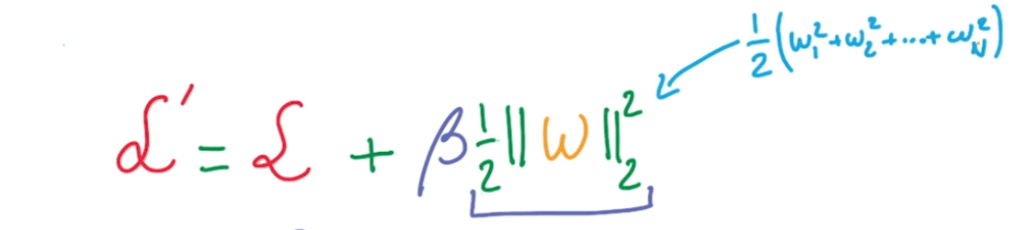

1. Load Data & Build Computation Graph

   ຂັ້ນຕອນການສ້າງອົງປະກອບ ແລະ ໃຫ້ຄ່າຕ່າງໆ ຂອງສົມຜົນ ກໍ່ຄືໃຫ້ຄ່າຕ່າງໆຂອງໂຄງຮ່າງການປະເມີນຜົນ

In [26]:
# This is to expedite the process 
### ຢູຸ່ Assignment 1 ໃຊ້ train dataset 200,000 ຮູບ ແຕ່ ຢູ່ ນີ້ໃຊ້ ພຽງ train_subset = 10,000 ຮູບ
train_subset = 10000
# This is a good beta value to start with
beta = 0.01

graph = tf.Graph()
with graph.as_default():

    # Input data.
    # They're all constants.
    tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
    print('ຢູຸ່ Assignment 1 ໃຊ້ train dataset 200,000 ຮູບ ແຕ່ ຢູ່ ນີ້ໃຊ້ ພຽງ train_subset = ',tf_train_dataset.shape[0],' ຮູບ' )
    print('ມື້ໜ້າລອງປ່ຽນຈຳນວນເບິ່ງ ເພາະສົ່ງໃສ Assignment 1 ໄດ້ 86.79999999% ແຕ່ ຂັ້ນຕອນ num_steps = 801 ໄດ້ປະມານ 89.0 ຄືບໍ່ຕ່າງກັນຫຼາຍທັງທີ່ເປັນວີທີໃໝ່')
    print('ແຕ່ກໍ່ເປັນການໃຊ້ຈຳນວນຂໍ້ມູນໜ້ອຍກວ່າຫຼາຍ ຈາກ 200,000 ຮູບ ເປັນ 10,000 ຮູຸບ')

    tf_train_labels = tf.constant(train_labels[:train_subset])
    print('tf_train_labels :', tf_train_labels.shape)
    
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables    
    # They are variables we want to update and optimize.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))

# ຖ້າເກີດ Error when running tensorflow in virtualenv: module 'tensorflow' has no attribute 'truncated_normal'
# ໃຫ້ແກ້ຕາມ https://stackoverflow.com/questions/58341433/error-when-running-tensorflow-in-virtualenv-module-tensorflow-has-no-attribut
# ມັນຈະວ່າ Keras 2.2.4 does not support TensorFlow 2.0 (it was released much before TF 2.0),
# so you can either downgrade TensorFlow to version 1.x,
# or upgrade Keras to version 2.3, which does support TensorFlow 2.0.
# ເຊິ່ງຂ້ອຍໃຊ້ downgrade TensorFlow to version 1.x,
# ດ້ວຍ   %tensorflow_version 1.x
#        import tensorflow as tf
#        print(tf.__version__)


    biases = tf.Variable(tf.zeros([num_labels]))
  
    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases 
    ###  ເລື້ມທຳອິດ weights ມີຄ່າແບບ ramdom ສ່ວນ biases = 0    
    # Original loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels) )
    ### ຢູ່   Assignment1 ບໍ່ມີ loss ມີ accuracy

    # Loss function using L2 Regularization
    regularizer = tf.nn.l2_loss(weights)
    loss = tf.reduce_mean(loss + beta * regularizer)
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.   ??? ມັນຫຍັງຕ້ອງ ຄາດເດົາຄ່າພວກນີ້ນຳ train_prediction 
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax( tf.matmul(tf_valid_dataset, weights) + biases )
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

ຢູຸ່ Assignment 1 ໃຊ້ train dataset 200,000 ຮູບ ແຕ່ ຢູ່ ນີ້ໃຊ້ ພຽງ train_subset =  10000  ຮູບ
ມື້ໜ້າລອງປ່ຽນຈຳນວນເບິ່ງ ເພາະສົ່ງໃສ Assignment 1 ໄດ້ 86.79999999% ແຕ່ ຂັ້ນຕອນ num_steps = 801 ໄດ້ປະມານ 89.0 ຄືບໍ່ຕ່າງກັນຫຼາຍທັງທີ່ເປັນວີທີໃໝ່
ແຕ່ກໍ່ເປັນການໃຊ້ຈຳນວນຂໍ້ມູນໜ້ອຍກວ່າຫຼາຍ ຈາກ 200,000 ຮູບ ເປັນ 10,000 ຮູຸບ
tf_train_labels : (10000, 10)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



1. Run Computation & Iterate

   ຂັ້ນຕອນການປະຕິບັດ ແລະ ຈະປະຕິບັດຊຳ້ອີກ ຂອງສົມຜົນທີ່ໄດ້ສ້າງມາ
   ເພື່ອເບິ່ງການປ່ຽນແປງຂອງ loss ແລະ accuracy

In [27]:
num_steps = 801

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

with tf.Session(graph=graph) as session:
    # This is a one-time operation which ensures the parameters get initialized as
    # we described in the graph: random weights for the matrix, zeros for the
    # biases.       
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays. 
        _, l, predictions = session.run([optimizer, loss, train_prediction])
### ຮ່າໆໆ ເບິ່ງໄປເບິ່ງມາກະເປັນຕາຫົວເນາະ ລັນຢູ່ແຖວດຽວນີ້ 800 ເທື່ອ ເປັນຄວາມສາມາດຂອງ tf
### ແລ້ວມັນລັນໂຕໃດກ່ອນ ລະຫວ່າງ optimizer, loss ແລະ train_prediction

### ອັນຂີດກ້ອງນີ້ _, ຄວາມໝາຍມັນແມ່ນຫຍັງນໍ?        
        if (step % 100 == 0):
            print('Loss at step {}: {}'.format(step, l))
            print('Training accuracy: {:.2f}'.format(accuracy(predictions, 
                                                         train_labels[:train_subset, :])))
            # Calling .eval() on valid_prediction is basically like calling run(), but
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
            
            # You don't have to do .eval above because we already ran the session for the
            # train_prediction
            print('Validation accuracy: {:.1f}'.format(accuracy(valid_prediction.eval(), 
                                                           valid_labels)))
    print('Test accuracy: {:.1f}'.format(accuracy(test_prediction.eval(), test_labels)))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Loss at step 0: 47.683937072753906
Training accuracy: 9.24
Validation accuracy: 11.4
Loss at step 100: 11.494377136230469
Training accuracy: 73.52
Validation accuracy: 72.3
Loss at step 200: 4.362926959991455
Training accuracy: 78.34
Validation accuracy: 76.7
Loss at step 300: 1.9463412761688232
Training accuracy: 81.41
Validation accuracy: 79.8
Loss at step 400: 1.1272419691085815
Training accuracy: 82.91
Validation accuracy: 81.2
Loss at step 500: 0.8461117148399353
Training accuracy: 83.51
Validation accuracy: 81.6
Loss at step 600: 0.7484318017959595
Training accuracy: 83.73
Validation accuracy: 81.7
Loss at step 700: 0.7141733765602112
Training accuracy: 83.84
Validation accuracy: 81.8
Loss at step 800: 0.7020689249038696
Training accuracy: 83.93
Validation accuracy: 81.7
Test accuracy: 89.2


Neural Network with L2 Regularization

1 Hidden Layer using RELUs

In [28]:
num_nodes= 1024
batch_size = 128
beta = 0.01

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_nodes]))
    biases_1 = tf.Variable(tf.zeros([num_nodes]))
    weights_2 = tf.Variable(tf.truncated_normal([num_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits_1 = tf.matmul(tf_train_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    # Normal loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits_2, labels =tf_train_labels))

# date 2020-05-25
# tf.nn.softmax_cross_entropy_with_logits(_sentinel=None, labels=None, logits=None, dim=-1, name=None, axis=None)
# Computes softmax cross entropy between logits and labels. (deprecated)
# Warning: THIS FUNCTION IS DEPRECATED. It will be removed in a future version. Instructions for updating:
# Future major versions of TensorFlow will allow gradients to flow into the labels input on backprop by default.
# See tf.nn.softmax_cross_entropy_with_logits_v2.
# Measures the probability error in discrete classification tasks in which the classes are mutually exclusive 
# (each entry is in exactly one class). For example, each CIFAR-10 image is labeled with one and only one label: 
# an image can be a dog or a truck, but not both.
# **NOTE:**  While the classes are mutually exclusive, their probabilities  
# need not be. All that is required is that each row of labels is a valid probability distribution. If they are not,
#  the computation of the gradient will be incorrect.
# If using exclusive labels (wherein one and only one class is true at a time), see sparse_softmax_cross_entropy_with_logits.
# **WARNING:** This op expects unscaled logits, since it performs a `softmax`  
# on logits internally for efficiency. Do not call this op with the output of softmax, as it will produce incorrect results.
# A common use case is to have logits and labels of shape [batch_size, num_classes], but higher dimensions are supported, 
# with the dim argument specifying the class dimension.
# Backpropagation will happen only into logits. To calculate a cross entropy loss that allows backpropagation into both 
# logits and labels, see tf.nn.softmax_cross_entropy_with_logits_v2.
# **Note that to avoid confusion, it is required to pass only named arguments to  
# this function.**
# Args:
#   _sentinel: Used to prevent positional parameters. Internal, do not use.  
#   labels: Each vector along the class dimension should hold a valid  
#     probability distribution e.g. for the case in which labels are of shape  


    # Loss function with L2 Regularization with beta=0.01
    regularizers = tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2)
    loss = tf.reduce_mean(loss + beta * regularizers)

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training
    train_prediction = tf.nn.softmax(logits_2)
    
    # Predictions for validation 
    logits_1 = tf.matmul(tf_valid_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    
    valid_prediction = tf.nn.softmax(logits_2)
    
    # Predictions for test
    logits_1 = tf.matmul(tf_test_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    
    test_prediction =  tf.nn.softmax(logits_2)

In [29]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step {}: {}".format(step, l))
            print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
            print("Validation accuracy: {:.1f}".format(accuracy(valid_prediction.eval(), valid_labels)))
    print("Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), test_labels)))

Initialized
Minibatch loss at step 0: 3476.864013671875
Minibatch accuracy: 12.5
Validation accuracy: 30.5
Minibatch loss at step 500: 21.375415802001953
Minibatch accuracy: 79.7
Validation accuracy: 84.6
Minibatch loss at step 1000: 0.886101245880127
Minibatch accuracy: 82.0
Validation accuracy: 83.5
Minibatch loss at step 1500: 0.6685487031936646
Minibatch accuracy: 85.9
Validation accuracy: 83.6
Minibatch loss at step 2000: 0.7251509428024292
Minibatch accuracy: 83.6
Validation accuracy: 83.5
Minibatch loss at step 2500: 0.6175293326377869
Minibatch accuracy: 87.5
Validation accuracy: 83.2
Minibatch loss at step 3000: 0.9254697561264038
Minibatch accuracy: 74.2
Validation accuracy: 83.9
Test accuracy: 90.5


Problem 2

Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

Continuing from the Neural Network with L2 Regularization above

In [30]:
num_steps = 3001

train_dataset_2 = train_dataset[:500, :]
train_labels_2 = train_labels[:500]

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels_2.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset_2[offset:(offset + batch_size), :]
        batch_labels = train_labels_2[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step {}: {}".format(step, l))
            print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
            print("Validation accuracy: {:.1f}".format(accuracy(valid_prediction.eval(), valid_labels)))
    print("Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), test_labels)))

Initialized
Minibatch loss at step 0: 3490.21728515625
Minibatch accuracy: 7.8
Validation accuracy: 29.1
Minibatch loss at step 500: 21.103267669677734
Minibatch accuracy: 100.0
Validation accuracy: 77.0
Minibatch loss at step 1000: 0.48421424627304077
Minibatch accuracy: 100.0
Validation accuracy: 77.2
Minibatch loss at step 1500: 0.30161774158477783
Minibatch accuracy: 100.0
Validation accuracy: 77.2
Minibatch loss at step 2000: 0.283530592918396
Minibatch accuracy: 100.0
Validation accuracy: 77.1
Minibatch loss at step 2500: 0.2768358886241913
Minibatch accuracy: 100.0
Validation accuracy: 77.1
Minibatch loss at step 3000: 0.27524638175964355
Minibatch accuracy: 100.0
Validation accuracy: 77.0
Test accuracy: 83.9


As you can see, there's high training accuracy but low validation accuracy. There is overfitting here.

Problem 3

Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides nn.dropout() for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?



In [31]:
num_nodes= 1024
batch_size = 128
beta = 0.01

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_nodes]))
    biases_1 = tf.Variable(tf.zeros([num_nodes]))
    weights_2 = tf.Variable(tf.truncated_normal([num_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    logits_1 = tf.matmul(tf_train_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1)
    # Dropout on hidden layer: RELU layer
    keep_prob = tf.placeholder("float")
    # WARNING:tensorflow:From <ipython-input-12-20bc49b7b7ef>:26: calling dropout (from tensorflow.python.ops.nn_ops) with 
    # keep_prob is deprecated and will be removed in a future version.
    # Instructions for updating:
    # Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

    relu_layer_dropout = tf.nn.dropout(relu_layer, keep_prob)
    
    logits_2 = tf.matmul(relu_layer_dropout, weights_2) + biases_2
    # Normal loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits_2, labels = tf_train_labels))
    # Loss function with L2 Regularization with beta=0.01
    regularizers = tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2)
    loss = tf.reduce_mean(loss + beta * regularizers)

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training
    train_prediction = tf.nn.softmax(logits_2)
    
    # Predictions for validation 
    logits_1 = tf.matmul(tf_valid_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    
    valid_prediction = tf.nn.softmax(logits_2)
    
    # Predictions for test
    logits_1 = tf.matmul(tf_test_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    
    test_prediction =  tf.nn.softmax(logits_2)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [32]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : 0.5}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step {}: {}".format(step, l))
            print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
            print("Validation accuracy: {:.1f}".format(accuracy(valid_prediction.eval(), valid_labels)))
    print("Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), test_labels)))

Initialized
Minibatch loss at step 0: 3716.180908203125
Minibatch accuracy: 8.6
Validation accuracy: 23.4
Minibatch loss at step 500: 21.527236938476562
Minibatch accuracy: 78.1
Validation accuracy: 83.7
Minibatch loss at step 1000: 0.9519579410552979
Minibatch accuracy: 82.0
Validation accuracy: 82.8
Minibatch loss at step 1500: 0.74945068359375
Minibatch accuracy: 85.9
Validation accuracy: 83.1
Minibatch loss at step 2000: 0.8026576638221741
Minibatch accuracy: 82.0
Validation accuracy: 83.1
Minibatch loss at step 2500: 0.6801612377166748
Minibatch accuracy: 86.7
Validation accuracy: 82.6
Minibatch loss at step 3000: 0.9686069488525391
Minibatch accuracy: 74.2
Validation accuracy: 83.4
Test accuracy: 89.9


Extreme Overfitting

In [33]:
num_steps = 3001
beta = 0.01

train_dataset_2 = train_dataset[:500, :]
train_labels_2 = train_labels[:500]

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels_2.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset_2[offset:(offset + batch_size), :]
        batch_labels = train_labels_2[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,  keep_prob : 0.5}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step {}: {}".format(step, l))
            print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
            print("Validation accuracy: {:.1f}".format(accuracy(valid_prediction.eval(), valid_labels)))
    print("Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), test_labels)))

Initialized
Minibatch loss at step 0: 3625.32958984375
Minibatch accuracy: 12.5
Validation accuracy: 37.3
Minibatch loss at step 500: 21.163591384887695
Minibatch accuracy: 99.2
Validation accuracy: 76.8
Minibatch loss at step 1000: 0.5126768350601196
Minibatch accuracy: 100.0
Validation accuracy: 77.5
Minibatch loss at step 1500: 0.33722013235092163
Minibatch accuracy: 100.0
Validation accuracy: 77.6
Minibatch loss at step 2000: 0.3178301155567169
Minibatch accuracy: 100.0
Validation accuracy: 77.3
Minibatch loss at step 2500: 0.30229055881500244
Minibatch accuracy: 100.0
Validation accuracy: 77.4
Minibatch loss at step 3000: 0.30991989374160767
Minibatch accuracy: 99.2
Validation accuracy: 77.4
Test accuracy: 84.1


Problem 4

Try to get the best performance you can using a multi-layer model! The best 

reported test accuracy using a deep network is 97.1%.

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

global_step = tf.Variable(0)  # count the number of steps taken.

learning_rate = tf.train.exponential_decay(0.5, global_step, ...)

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

Model

  - 5 hidden layers NN

    - RELUs

    - Number of nodes decrease by 50% with each hidden layer that is deeper in  
      the neural net

  - Overfitting measures

    - L2 Regularization

      - Learning rate (beta) with exponential decay

    - Dropout

  - 10,000 steps

In [34]:
import math as math

In [35]:
batch_size = 128
beta = 0.001

hidden_nodes_1 = 1024
hidden_nodes_2 = int(hidden_nodes_1 * 0.5)
hidden_nodes_3 = int(hidden_nodes_1 * np.power(0.5, 2))
hidden_nodes_4 = int(hidden_nodes_1 * np.power(0.5, 3))
hidden_nodes_5 = int(hidden_nodes_1 * np.power(0.5, 4))

graph = tf.Graph()
with graph.as_default():

    '''Input Data'''
    # For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    '''Variables'''
    # Hidden RELU layer 1
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes_1], stddev=math.sqrt(2.0/(image_size*image_size))))
    biases_1 = tf.Variable(tf.zeros([hidden_nodes_1]))

    # Hidden RELU layer 2
    weights_2 = tf.Variable(tf.truncated_normal([hidden_nodes_1, hidden_nodes_2], stddev=math.sqrt(2.0/hidden_nodes_1)))
    biases_2 = tf.Variable(tf.zeros([hidden_nodes_2]))
    
    # Hidden RELU layer 3
    weights_3 = tf.Variable(tf.truncated_normal([hidden_nodes_2, hidden_nodes_3], stddev=math.sqrt(2.0/hidden_nodes_2)))
    biases_3 = tf.Variable(tf.zeros([hidden_nodes_3]))
    
    # Hidden RELU layer 4
    weights_4 = tf.Variable(tf.truncated_normal([hidden_nodes_3, hidden_nodes_4], stddev=math.sqrt(2.0/hidden_nodes_3)))
    biases_4 = tf.Variable(tf.zeros([hidden_nodes_4]))
    
    # Hidden RELU layer 5
    weights_5 = tf.Variable(tf.truncated_normal([hidden_nodes_4, hidden_nodes_5], stddev=math.sqrt(2.0/hidden_nodes_4)))
    biases_5 = tf.Variable(tf.zeros([hidden_nodes_5]))
    
    # Output layer
    weights_6 = tf.Variable(tf.truncated_normal([hidden_nodes_5, num_labels], stddev=math.sqrt(2.0/hidden_nodes_5)))
    biases_6 = tf.Variable(tf.zeros([num_labels]))
    
    '''Training computation'''
    
    # Hidden RELU layer 1
    logits_1 = tf.matmul(tf_train_dataset, weights_1) + biases_1
    hidden_layer_1 = tf.nn.relu(logits_1)
    # Dropout on hidden layer: RELU layer
    keep_prob = tf.placeholder("float")
    hidden_layer_1_dropout = tf.nn.dropout(hidden_layer_1, keep_prob)
    
    
    # Hidden RELU layer 2
    logits_2 = tf.matmul(hidden_layer_1_dropout, weights_2) + biases_2
    hidden_layer_2 = tf.nn.relu(logits_2)
    # Dropout on hidden layer: RELU layer
    hidden_layer_2_dropout = tf.nn.dropout(hidden_layer_2, keep_prob)
    
    # Hidden RELU layer 3
    logits_3 = tf.matmul(hidden_layer_2_dropout, weights_3) + biases_3
    hidden_layer_3 = tf.nn.relu(logits_3)
    # Dropout on hidden layer: RELU layer
    hidden_layer_3_dropout = tf.nn.dropout(hidden_layer_3, keep_prob)
    
    # Hidden RELU layer 4
    logits_4 = tf.matmul(hidden_layer_3_dropout, weights_4) + biases_4
    hidden_layer_4 = tf.nn.relu(logits_4)
    # Dropout on hidden layer: RELU layer

    hidden_layer_4_dropout = tf.nn.dropout(hidden_layer_4, keep_prob)
    
    # Hidden RELU layer 5
    logits_5 = tf.matmul(hidden_layer_4_dropout, weights_5) + biases_5
    hidden_layer_5 = tf.nn.relu(logits_5)
    # Dropout on hidden layer: RELU layer
    hidden_layer_5_dropout = tf.nn.dropout(hidden_layer_5, keep_prob)
    
    # Output layer
    logits_6 = tf.matmul(hidden_layer_5_dropout, weights_6) + biases_6 
    
    # Normal loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits_6, labels = tf_train_labels))
    # Loss function with L2 Regularization with decaying learning rate beta=0.5
    regularizers = tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) + \
                   tf.nn.l2_loss(weights_3) + tf.nn.l2_loss(weights_4) + \
                   tf.nn.l2_loss(weights_5) + tf.nn.l2_loss(weights_6)
    loss = tf.reduce_mean(loss + beta * regularizers)

    '''Optimizer'''
    # Decaying learning rate
    global_step = tf.Variable(0)  # count the number of steps taken.
    start_learning_rate = 0.5
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 100000, 0.96, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # Predictions for the training
    train_prediction = tf.nn.softmax(logits_6)
    
    # Predictions for validation 
    valid_logits_1 = tf.matmul(tf_valid_dataset, weights_1) + biases_1
    valid_relu_1 = tf.nn.relu(valid_logits_1)
    
    valid_logits_2 = tf.matmul(valid_relu_1, weights_2) + biases_2
    valid_relu_2 = tf.nn.relu(valid_logits_2)
    
    valid_logits_3 = tf.matmul(valid_relu_2, weights_3) + biases_3
    valid_relu_3 = tf.nn.relu(valid_logits_3)
    
    valid_logits_4 = tf.matmul(valid_relu_3, weights_4) + biases_4
    valid_relu_4 = tf.nn.relu(valid_logits_4)
    
    valid_logits_5 = tf.matmul(valid_relu_4, weights_5) + biases_5
    valid_relu_5 = tf.nn.relu(valid_logits_5)
    
    valid_logits_6 = tf.matmul(valid_relu_5, weights_6) + biases_6
    
    valid_prediction = tf.nn.softmax(valid_logits_6)
    
    # Predictions for test
    test_logits_1 = tf.matmul(tf_test_dataset, weights_1) + biases_1
    test_relu_1 = tf.nn.relu(test_logits_1)
    
    test_logits_2 = tf.matmul(test_relu_1, weights_2) + biases_2
    test_relu_2 = tf.nn.relu(test_logits_2)
    
    test_logits_3 = tf.matmul(test_relu_2, weights_3) + biases_3
    test_relu_3 = tf.nn.relu(test_logits_3)
    
    test_logits_4 = tf.matmul(test_relu_3, weights_4) + biases_4
    test_relu_4 = tf.nn.relu(test_logits_4)
    
    test_logits_5 = tf.matmul(test_relu_4, weights_5) + biases_5
    test_relu_5 = tf.nn.relu(test_logits_5)
    
    test_logits_6 = tf.matmul(test_relu_5, weights_6) + biases_6
    
    test_prediction = tf.nn.softmax(test_logits_6)

In [36]:
num_steps = 15000            ### step ນີ້ລັນຄັ້ງທຳອິດ 733.411ວິນາທີ = 12.22ນາທີ

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : 0.5}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step {}: {}".format(step, l))
            print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
            print("Validation accuracy: {:.1f}".format(accuracy(valid_prediction.eval(), valid_labels)))
    print("Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), test_labels)))

### 200524 ກອບປີ້ມາແລ້ວມື້ນີ້
### 200525 ລັນຜ່ານຄັ້ງທຳອິດ ### step ນີ້ລັນຄັ້ງທຳອິດ 733.411ວິນາທີ = 12.22ນາທີ

Initialized
Minibatch loss at step 0: 4.613100051879883
Minibatch accuracy: 10.2
Validation accuracy: 10.7
Minibatch loss at step 500: 2.0181736946105957
Minibatch accuracy: 74.2
Validation accuracy: 82.7
Minibatch loss at step 1000: 1.3136873245239258
Minibatch accuracy: 82.8
Validation accuracy: 83.7
Minibatch loss at step 1500: 1.088275671005249
Minibatch accuracy: 86.7
Validation accuracy: 84.3
Minibatch loss at step 2000: 1.0702412128448486
Minibatch accuracy: 81.2
Validation accuracy: 84.4
Minibatch loss at step 2500: 0.8112349510192871
Minibatch accuracy: 89.1
Validation accuracy: 85.4
Minibatch loss at step 3000: 1.075466513633728
Minibatch accuracy: 77.3
Validation accuracy: 85.6
Minibatch loss at step 3500: 0.7931531667709351
Minibatch accuracy: 82.0
Validation accuracy: 85.7
Minibatch loss at step 4000: 0.7554179430007935
Minibatch accuracy: 88.3
Validation accuracy: 85.6
Minibatch loss at step 4500: 0.9653371572494507
Minibatch accuracy: 80.5
Validation accuracy: 86.0
Minib

# Test

In [37]:
#import numpy as np
#import tensorflow as tf

b = np.arange(6)
b[3] = 9
print(b)
np.argmax(b)


[0 1 2 9 4 5]


3